In [25]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

import costfun.costfun as cost

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

base_dir = "../results/"


/ceph/hpc/scratch/user/rswietek/QHamSolver/QuantumSun/Jupyter_Python
/ceph/hpc/scratch/user/rswietek/QHamSolver/QuantumSun
/cvmfs/sling.si/modules/el7/software/Anaconda3/2022.05/lib/python39.zip
/cvmfs/sling.si/modules/el7/software/Anaconda3/2022.05/lib/python3.9
/cvmfs/sling.si/modules/el7/software/Anaconda3/2022.05/lib/python3.9/lib-dynload

/ceph/hpc/home/rswietek/.local/lib/python3.9/site-packages
/cvmfs/sling.si/modules/el7/software/Anaconda3/2022.05/lib/python3.9/site-packages
../../Python/
../../Python/
../../Python/


In [42]:
def order_of_magnitude(a_value):
    #return 2
    if np.abs(a_value) < 1.0 and a_value != 0:
        m = np.abs(np.log10(np.abs(a_value)))
        return int(max(math.ceil(m) + 1., 2.))
    else: 
        return 2

def info_raw(L, M, J, gamma, zeta, alfa, h, w, ini_ave = 0):
    arr = [J, gamma, zeta, alfa, h, w]
    names = ['J', 'g', 'zeta', 'alfa', 'h', 'w']
    info = "_L=%d,M=%d"%(L,M)
    for i, var in enumerate(arr):
        n = order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    info += ",ini_ave=%d"%ini_ave
    return info

def info(L, M, J, gamma, zeta, alfa, h, w, ini_ave = 0):
    return info_raw(L, M, J, gamma, zeta, alfa, h, w, ini_ave) + ".dat"


def GOE(x : np.array):
    """
    GOE shape of sff in thermodynamic limit
    
    Parameters:
    -----------------
        x : np.array
            numpy array with datapoints (times defined for unfolded data)
    """
    return np.array([2 * a - a * np.log(1 + 2 * a) if a < 1 else 2 - a * np.log( (2 * a + 1) / (2 * a - 1) ) for a in x])

def remove_fluctuations(data, bucket_size=10):
    new_data = data;
    half_bucket = int(bucket_size / 2)
    for k in range(half_bucket, len(data) - half_bucket):
        average = np.sum(data[k - half_bucket : k + half_bucket])
        new_data[k - half_bucket] = average / bucket_size
    return new_data

dir_E = base_dir + 'DIAGONALIZATION/'

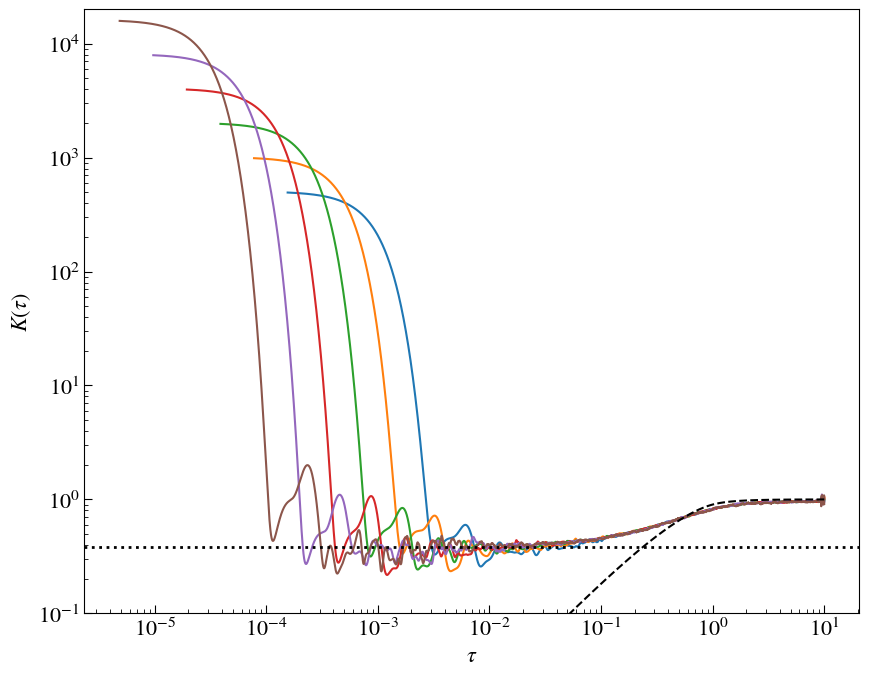

In [3]:
J=1.0
alfa=0.75
h=0.5
w=1.0
zeta=0.2
M=3
ini_ave=0

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,8), dpi = 100)

FOLDED = False

alfa_vals = np.linspace(0.7, 0.85, 16)
sizes = np.arange(10, 16, 1)
#for alfa in alfa_vals:
times = [1]
for L in sizes:
    filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, zeta, alfa, h, w, ini_ave)
    if exists(filename):
        data = pd.read_table(filename, sep="\t", header=None)
        times = np.array(data[0])
        sff = np.array(data[1])
        sff = remove_fluctuations(sff, int(0.005 * len(sff)))
        tH = data[2][0]
        gap_ratio = data[4][0]
        axis.plot(times, sff, lw=1.5, label=r"$L=%d$"%L)
    else:
        print(filename)

axis.plot(times, GOE(times), ls='--', color='black')
axis.axhline(y=0.38, ls=':', lw=2, color='black')
axis.set_ylim(1e-1, 2e4)
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_ylabel(r"$K(\tau)$", fontsize=16)
axis.set_xlabel(r"$\tau$", fontsize=16)
axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
#axis.set_ylim(0, 1.1)

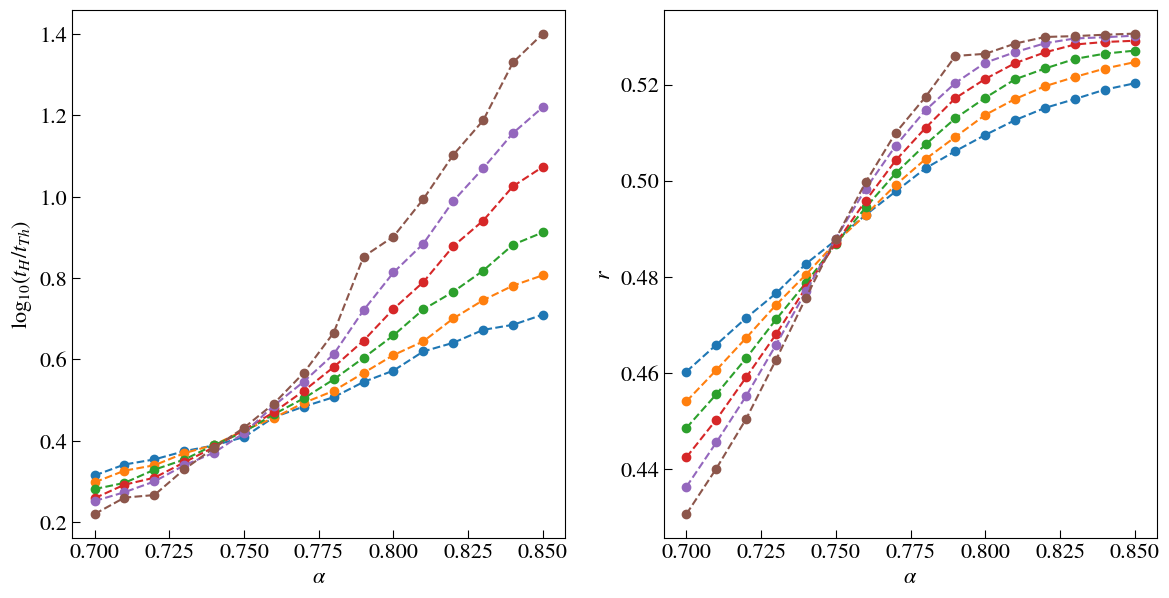

In [4]:
J=1.0
alfa=0.75
h=0.5
w=1.0
zeta=0.2
M=3
ini_ave=0

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(14,7), dpi = 100)

FOLDED = False

alfa_vals = np.linspace(0.7, 0.85, 16)
sizes = np.arange(10, 16, 1)

taus = []
gaps = []
heisenberg_time = []
times = [1]

epsilon=8e-2
for L in sizes:
    tau_L = []
    tH_L = []
    gaps_L = []
    for alfa in alfa_vals:
    
        filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, zeta, alfa, h, w, ini_ave)
        if exists(filename):
            data = pd.read_table(filename, sep="\t", header=None)
            times = np.array(data[0])
            sff = np.array(data[1])
            sff = remove_fluctuations(sff, int(0.01 * len(sff)))
            tH = data[2][0]
            gap_ratio = data[4][0]
            times_for_algorithm = times / tH if FOLDED else times
            sff_dev = np.abs(np.log10(sff / GOE(times_for_algorithm)))
            tau = np.nan
            for i, K in reversed(list(enumerate(sff_dev))):
                if K > epsilon and times[i] < (3 * tH if FOLDED else 3):
                    tau = times[i-1]
                    break
            tau_L.append(tau)
            tH_L.append(tH)
            gaps_L.append(gap_ratio)
            
            #axis.plot(times, sff, lw=1.5, label=r"$L=%d$"%L)
        else:
            tau_L.append(np.nan)
            tH_L.append(np.nan)
            gaps_L.append(np.nan)
            print(filename)
    tau_L = np.array(tau_L)
    tH_L = np.array(tH_L)

    taus.append(tau_L)
    heisenberg_time.append(tH_L)

    axis[0].plot(alfa_vals, np.log10(1.0 / tau_L), ls='--', marker='o')
    axis[1].plot(alfa_vals, gaps_L, ls='--', marker='o')
    
#axis.plot(times, GOE(times), ls='--', color='black')
axis[0].set_ylabel(r"$\log_{10}(t_H/t_{Th})$", fontsize=16)
axis[1].set_ylabel(r"$r$", fontsize=16)
for ax in axis:
    ax.set_xlabel(r"$\alpha$", fontsize=16)
    
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
    ax.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
#axis.set_ylim(0, 1.1)

In [ ]:
alfa_vals = np.linspace(0.7, 0.85, 16)

num_of_points = 50
gap_ratio = []
ener = []
L = 15


sizes2 = np.arange(12, 16, 1)
for L in sizes2:
    gap_ratio_L = []
    ener_L = []

    for alfa in alfa_vals:
        r_mean = np.zeros((50))
        ener_L = np.zeros((50))

        counter = 0
        for realis in range(1000 if L < 13 else (2500 if L < 14 else 5000)):
            filename = dir_E + info_raw(L, M, J, zeta, alfa, h, w, ini_ave) + "_real=%d"%realis + ".hdf5"

            if exists(filename):
                counter += 1
                with h5py.File(filename, "r") as file:
                    E = np.array(file.get('eigenvalues/dataset')[0])
                    dim = E.size

                    gaps = np.diff(E)
                    ratio = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])

                    E_rescaled = (E - np.min(E)) / (np.max(E) - np.min(E))
                    for k in range(0, num_of_points):
                        r_mean[k] += np.mean(ratio[ k * (dim // num_of_points) : (k+1) * (dim // num_of_points) ])
                        ener_L[k] += np.mean(E_rescaled[ k * (dim // num_of_points) : (k+1) * (dim // num_of_points) ])
        
        gap_ratio_L.append(r_mean / counter)
        ener_L /= counter
        
        print(L, alfa, counter)
        
    with open(f'rescaled_energy_L={L}.npy', 'wb') as file: np.save(file, ener_L, allow_pickle=True)
    with open(f'gap_ratio_L={L}.npy', 'wb') as file: np.save(file, np.array(gap_ratio_L), allow_pickle=True)

    gap_ratio.append( np.array(gap_ratio_L) )
    ener.append( np.array(ener_L) )



In [5]:

gap_ratio = []
ener = []
for L in sizes:
    with open(f'rescaled_energy_L={L}.npy', 'rb') as file: ener_L = np.load(file, allow_pickle=True)
    with open(f'gap_ratio_L={L}.npy', 'rb') as file:       gap_ratio_L = np.load(file, allow_pickle=True)
    gap_ratio.append( np.array(gap_ratio_L) )
    ener.append( np.array(ener_L) )

0.8285438235669647
0.5594898476131753 [0.82854382] 1.564726684287217 True Generator(PCG64) 0.19239067900830065 0.8285438235669647
0.7758281858105135
0.35272631470667903 [0.77582819] 1.4886561596327157 True Generator(PCG64) 0.26258208369837144 0.7758281858105135
0.7637511228554892
0.35278124692549984 [0.76375112] 0.4732216093925008 True Generator(PCG64) 0.29657635495900225 0.7637511228554892
0.760090015774237
0.37909007280900564 [0.76009002] 0.6929338872221724 True Generator(PCG64) 0.3214800726479698 0.760090015774237
0.7572304893160483
0.38650938585630357 [0.75723049] 0.635184391445383 True Generator(PCG64) 0.3417270323213977 0.7572304893160483
0.7517501341434848
0.39876633497511715 [0.75175013] 0.41116694930841047 True Generator(PCG64) 0.3591255245020293 0.7517501341434848
0.752273097534483
0.4106325160538917 [0.7522731] 0.40032967833812694 True Generator(PCG64) 0.3746344157206337 0.752273097534483
0.7504071728847089
0.37596799183328944 [0.75040717] 0.4320323908534509 True Generator(P

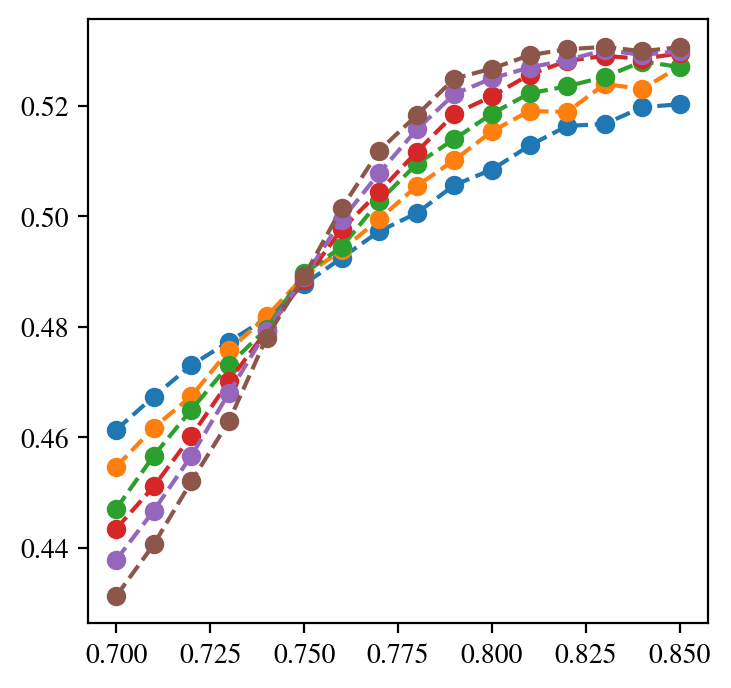

In [38]:
fig, axis = plt.subplots(ncols=1, nrows=1, dpi=200, figsize=(4, 4))

idx0 = 15
eps = []
alfa_crit = []
for idx in range(35):
    xdata = []
    ydata = []
    for jj, L in enumerate(sizes):
        ratio = []
        for ii, alfa in enumerate(alfa_vals):
            ratio.append(gap_ratio[jj][ii][idx])

        if idx == idx0:
            axis.plot(alfa_vals, ratio, label=r"$L=%d$", ls='--', marker='o')

        xdata.append(np.array(alfa_vals))
        ydata.append(np.array(ratio))
    
    critical = 0
    for r in range(1):
        seed = np.random.default_rng()
        par, crit_pars, costfun, status = cost.get_crit_points(x=np.array(xdata), y=np.array(ydata), vals=sizes, crit_fun='const', scaling_ansatz='RG', seed=seed)
        print(crit_pars[-1])
        
        critical += np.log(crit_pars[-1])
    
    critical = np.exp(critical / 1.0)
    
    print(par, crit_pars, costfun, status, seed, ener[-1][idx], critical)
    eps.append(ener[-1][idx])    
    alfa_crit.append(crit_pars[-1]) 

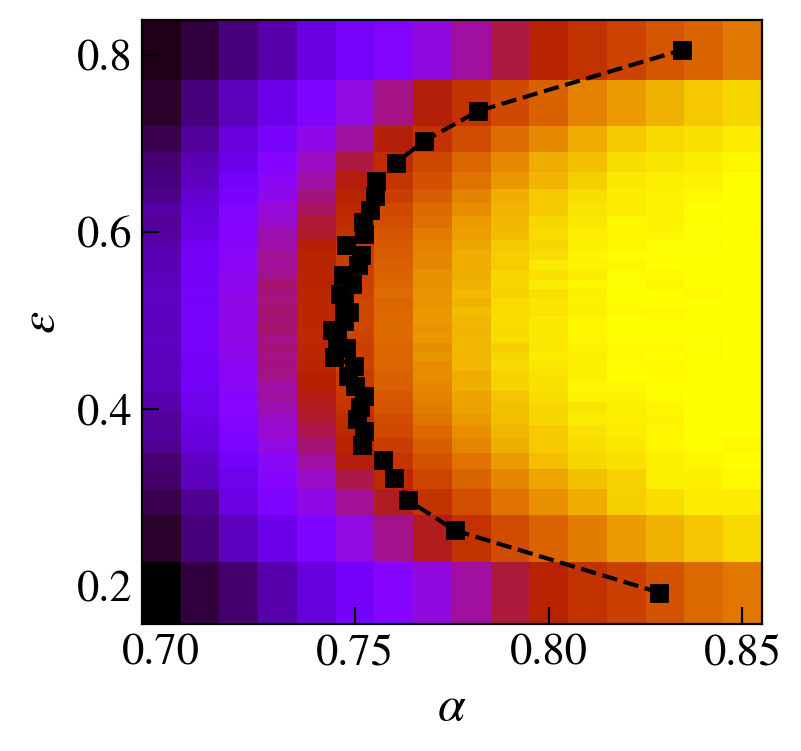

In [39]:
fig, axis = plt.subplots(ncols=1, nrows=1, dpi=200, figsize=(4, 4))

E_range = np.linspace(0.0, 1.0, 50)

X, Y = np.meshgrid(alfa_vals, ener[-1])

p = axis.pcolormesh(X, Y, np.transpose(gap_ratio[-1]), shading='nearest', vmax=0.5307, cmap = 'gnuplot')

axis.set_ylabel(r'$\epsilon$', fontsize=18)
axis.set_xlabel(r'$\alpha$', fontsize=18)
axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
#axis.pcolormesh

axis.plot(alfa_crit, eps, marker='s', ls='--', color='black')

plt.savefig("MobilityEdge.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("MobilityEdge.png", bbox_inches = 'tight', pad_inches=0.02)

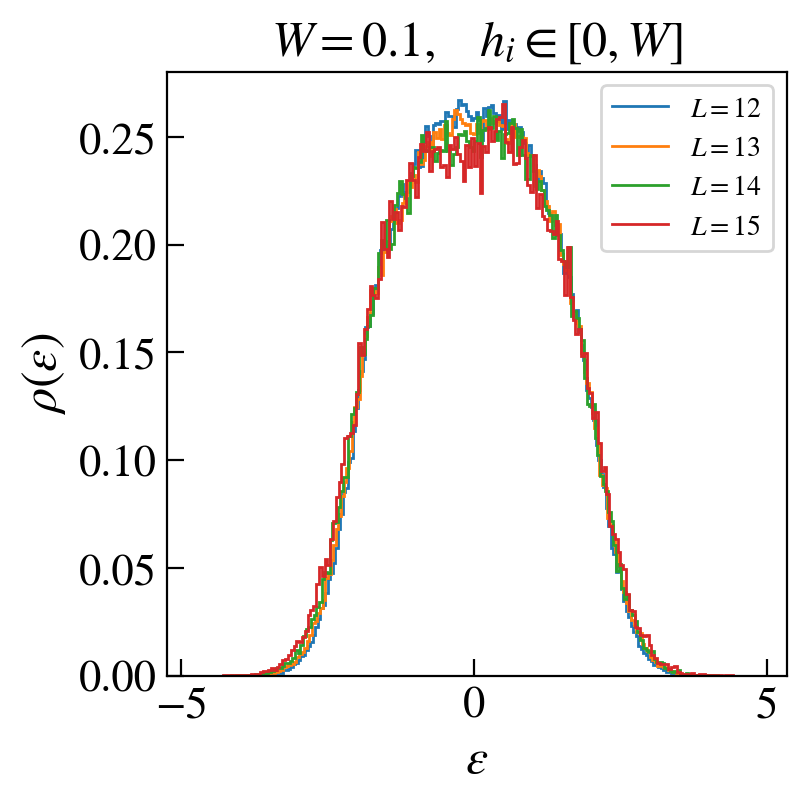

: 

In [91]:
L=15
alfa=1.0
gamma=1.
h=0.0
w=0.1

fig, axis = plt.subplots(ncols=1, nrows=1, dpi=200, figsize=(4, 4))
for L in [12, 13, 14, 15]:
#for w in [0.5, 1.0, 2.0, 3.0]:
    energies = []
    for realis in range(1000):
        filename = dir_E + info_raw(L, M, J, gamma, zeta, alfa, h, w, ini_ave) + "_real=%d"%realis + ".hdf5"

        if exists(filename):
            with h5py.File(filename, "r") as file:
                E = np.array(file.get('eigenvalues/dataset')[0])
                dim = E.size
                energies = [*energies, *E]
    hist, bins = np.histogram(energies, bins = 200, normed=True)
    axis.stairs(hist, bins, label=r"$L=%d$"%L)
    #axis.stairs(hist, np.array(bins) / w, label=r"$W=%.1f$"%w)


axis.set_ylabel(r'$\rho(\epsilon)$', fontsize=18)
axis.set_xlabel(r'$\epsilon$', fontsize=18)
axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
axis.legend()
#axis.set_xlim(-5, 5)

axis.set_title(f"$W={w},\quad h_i\in[0,W]$", fontsize=18)
plt.savefig(f"DOS_L={L}.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig(f"DOS_L={L}.png", bbox_inches = 'tight', pad_inches=0.02)
